# compute spectra on mitgcm outputs

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
#from dask_jobqueue import PBSCluster
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.47:8786 Dashboard: http://10.148.0.47:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


--- 

# load data

In [6]:
v = 'Eta'
face = 1

## open files, binary files
#data_dir = root_data_dir+v+'/'
#iters, time = get_iters_time(v, data_dir, delta_t=25.)
#ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)


## open files, nc files
#ncdata_dir = datawork+'/mit_nc_t/'
ncdata_dir = scratch+'/mit_nc_t/'
# search for right files, for example: Eta_f01_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
filenames = filenames[:2]
print('Number of files processed: %d' %len(filenames))

Number of files available: 24
Number of files processed: 2


In [35]:
#%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')

ds = ds.isel(time=slice(0,3000))

grid = xr.open_dataset('/home1/scratch/aponte/mit_grid.nc', chunks={'i':10, 'j':432}, decode_coords=True)
grid = grid.isel(face=face)
ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 116 ms, sys: 12 ms, total: 128 ms
Wall time: 140 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (j, i) float32 dask.array<shape=(4320, 4320), chunks

In [38]:
#chunks={'time': len(ds['time']), 'face':1,  'i': 100, 'j': 100}
#chunks={'time': len(ds['time']), 'i': 10, 'j': 432}
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.39 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (j, i) float32 dask.array<shape=(4320, 4320), chunksize=

In [39]:
#%time eta = ds['Eta'].isel(face=1).persist()
%time eta = ds['Eta'].persist()
#%time eta = ds['Eta']

CPU times: user 4.86 s, sys: 56 ms, total: 4.91 s
Wall time: 4.92 s


---

# spectral computations 

In [10]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False).mean(dim=('i','j'))
E = E.astype('f8').rename('eta_power_spectrum ()')

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [11]:
%time E.load()

CPU times: user 23.6 s, sys: 264 ms, total: 23.9 s
Wall time: 3min 12s


<xarray.DataArray 'eta_power_spectrum ()' (freq_time: 480)>
array([5.928565e-10, 1.403779e+02, 2.312437e+02, ..., 8.740686e+01,
       2.312437e+02, 1.403779e+02])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07

No handles with labels found to put in legend.


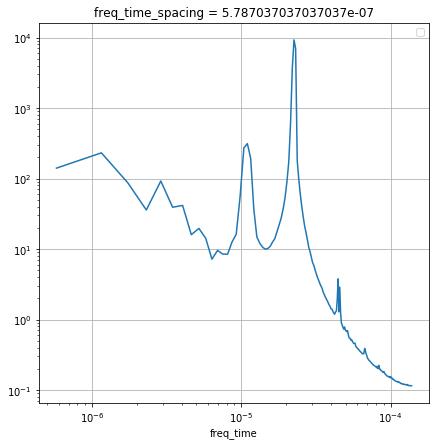

In [13]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
E.where(E.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
#ax.set_ylim([1e-1,1e5])

---
# i averaged

In [18]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False).mean(dim=('i'))
E = E.astype('f8').rename('eta_power_spectrum ()')
%time E.load()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


CPU times: user 20.8 s, sys: 204 ms, total: 21 s
Wall time: 5min 39s


<xarray.DataArray 'eta_power_spectrum ()' (j: 4320, freq_time: 3000)>
array([[6.100417e-07, 1.709440e+04, 8.777749e+03, ..., 3.885412e+03,
        8.777749e+03, 1.709440e+04],
       [6.133078e-07, 1.695549e+04, 8.691818e+03, ..., 3.844150e+03,
        8.691818e+03, 1.695549e+04],
       [6.271161e-07, 1.682240e+04, 8.605289e+03, ..., 3.805105e+03,
        8.605289e+03, 1.682240e+04],
       ...,
       [6.401297e-08, 3.744548e+03, 6.442668e+02, ..., 3.887815e+02,
        6.442668e+02, 3.744548e+03],
       [7.888247e-08, 3.731280e+03, 6.406590e+02, ..., 3.971922e+02,
        6.406590e+02, 3.731280e+03],
       [5.328227e-08, 3.711034e+03, 6.334194e+02, ..., 4.055229e+02,
        6.334194e+02, 3.711034e+03]])
Coordinates:
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08

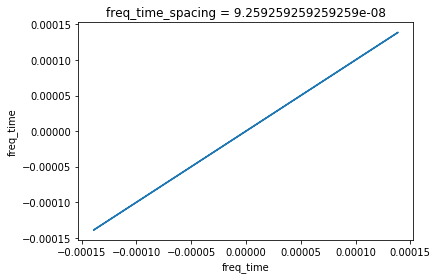

In [23]:
E['freq_time'].plot()
#E['j'].plot()

In [ ]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
plt.pcolormesh(np.log10(E.values))
#E.plot.pcolormesh(y=E['freq_time'], x=E['j'])
#np.log10(E).plot(ax=ax)
ax.legend(); ax.grid()
#ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel('');
#ax.set_ylim([1e-1,1e5])

No handles with labels found to put in legend.


In [17]:
ds['time'][1]-ds['time'][0]

<xarray.DataArray 'time' ()>
array(3600.)
Coordinates:
    face     int64 1

In [2]:
E.values()

NameError: name 'E' is not defined

---
# zonally averaged

In [40]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
print(v_fft)
print(eta)

<xarray.DataArray 'fftn-a42c5cc1bb1c29090f2c46b0b037c13b' (i: 4320, j: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=complex128, chunksize=(10, 432, 480)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07
<xarray.DataArray 'Eta' (i: 4320, j: 4320, time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float32, chunksize=(10, 432, 480)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
    XC       (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(432, 10)>
    YC       (j, i) float32 dask.array<shap

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [41]:
dlat = 1.
f = v_fft.freq_time
#f = f.where(f>0, drop=True)
print(f)

v1b = {'min': dlat*np.ceil(eta.YC.min().values/dlat),'max': dlat*np.floor(ds.YC.max().values/dlat), 'd': dlat}
#v2b = {'min': v_fft.freq_time.min().values, 'max': v_fft.freq_time.max().values, 'd': v_fft.freq_time[1]-v_fft.freq_time[0]}
v2b = {'min': f.min().values, 'max': f.max().values, 'd': f[1]-f[0]}
#v1min, v1max, dv1= dlat*np.ceil(ds.YC.min().values/dlat), dlat*np.floor(ds.YC.max().values/dlat), 1.
#v2min, v2max, dv2= v_fft.freq_time.min().values, v_fft.freq_time.max().values, v_fft.freq_time[1]-v_fft.freq_time[0]
i1max = int(np.rint((v1max-v1min)/dv1))+1
i2max = int(np.rint((v2max-v2min)/dv2))+1
def fmap(v1,v2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        i1max = np.int(np.rint((v1b['max']-v1b['min'])/v1b['d']))+1
        i2max = np.int(np.rint((v2b['max']-v2b['min'])/v2b['d']))+1
        #
        i1 = np.maximum(np.rint((v1-v1b['min'])/v1b['d'])+1,0)
        i1 = np.minimum(i1,i1max)
        #
        i2 = np.maximum(np.rint((v2-v2b['min'])/v2b['d'])+1,0)
        i2 = np.minimum(i2,i2max)
        return i1+i2*(i1max+1)

#def imap(i)
#    return lat, f

def printb(v,label):
    print('%s: min %e, max %e, step %e '%(label, v['min'], v['max'], v['d']) )

printb(v1b, 'lat')
printb(v2b, 'freq')

print(fmap(-40.,1e-3))
    

<xarray.DataArray 'freq_time' (freq_time: 480)>
array([ 0.000000e+00,  5.787037e-07,  1.157407e-06, ..., -1.736111e-06,
       -1.157407e-06, -5.787037e-07])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07


KeyboardInterrupt: 

In [ ]:
lat = ds.YC + 0*v_fft.freq_time
f = ds.YC*0. + v_fft.freq_time
print(lat)
print(f)

In [30]:
i = fmap(lat, f)
print(i)

i.isel(i=slice(0,100), j=slice(0,100), freq_time=0).plot()

<xarray.DataArray (j: 4320, i: 4320, freq_time: 480)>
dask.array<shape=(4320, 4320, 480), dtype=float64, chunksize=(4320, 4320, 480)>
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    face               int64 1
    XC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    rA                 (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    Depth              (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07


KeyboardInterrupt: 

In [27]:
    
# apply get_index to v1 and v2 arrays
v12 = dask.array.map_blocks(fmap, lat.data, f.data, dtype='float')
# compute histogram of linear indices
#h, lbins = dask.array.histogram(v12, bins=np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.))
print(v12)

dask.array<fmap, shape=(4320, 4320, 480), dtype=float64, chunksize=(4320, 4320, 480)>


In [37]:
#v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False) #.groupby('YC') #.mean(dim=('i'))
E = xr.merge([E,grid])
dlat = 1.
lat_bins = dlat*np.arange(np.ceil(E.YC.min().values/dlat), np.floor(E.YC.max().values/dlat))
print(lat_bins)
print(E)
E = E.groupby_bins('YC', lat_bins) #.mean(dim=['i','j'])
print(E)
#E = E.astype('f8').rename('eta_power_spectrum ()')
#%time E.load()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[-57. -56. -55. -54. -53. -52. -51. -50. -49. -48. -47. -46. -45. -44.
 -43. -42. -41. -40. -39. -38. -37. -36. -35. -34. -33. -32. -31. -30.
 -29. -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17. -16.
 -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.
  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.]
<xarray.Dataset>
Dimensions:                                (freq_time: 480, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i                                      (i) int64 0 1 2 3 4 5 6 7 8 9 10 ...
  * j                                      (j) int64 0 1 2 3 4 5 6 7 8 9 10 ...
  * freq_time                              (freq_time) float64 0.0 5.787e-07 ...
    freq_time_spacing                      float64 5.787e-07
  * i_g                                    (i_g) int64 0 1 2 3 4 5 6 7 8 9 ...
  * j_g                                    (j_g) int64 0 1 2 3 4 5 6 7 8 9 ...
  * k              

Client Scheduler: tcp://10.148.0.44:8786 Dashboard: http://10.148.0.44:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


---

In [13]:
client.restart()

Client Scheduler: tcp://10.148.0.44:8786 Dashboard: http://10.148.0.44:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


In [14]:
print(datawork)

/home1/datawork/aponte


In [ ]:

data_dir = root_data_dir+'Eta/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
